# SVM Optimization
This notebook is prepared to solve Support Vector Machine problem using `pyomo` optimization python package. You can download `pyomo` using the command below:
```shell
pip install pyomo
```

## What is Support Vector Machine?
The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.
Possible hyperplanes

To separate the two classes of data points, there are many possible hyperplanes that could be chosen. Our objective is to find a plane that has the maximum margin, i.e the maximum distance between data points of both classes. Maximizing the margin distance provides some reinforcement so that future data points can be classified with more confidence.

Reference: [Support Vector Machine — Introduction to Machine Learning Algorithms](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47)

# Import libraries
Python modules you need:
- pyomo
- matplotlib
- numpy
- scikit-learn

In [1]:
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs, make_moons, make_circles

# Create Dataset

## Generate sample input and output set

## Define Random State Seed

In [2]:
SEED = 42

## Simple Dataset

In [3]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1], [2, 0], [0, 2]])
y = np.array([-1, -1, -1, 1, 1, 1])

## Blobs Dataset

In [4]:
x_blob, y_blob = make_blobs(n_samples=1500, centers=2, cluster_std=1, n_features=2, random_state=SEED)
y_blob[y_blob == 0] = y_blob[y_blob == 0] - 1

## Moons Dataset

In [5]:
x_moon, y_moon = make_moons(n_samples = 1500, noise = 0.2, random_state=SEED)
y_moon[y_moon == 0] = y_moon[y_moon == 0] - 1

## Circles Dataset

In [6]:
x_circle, y_circle = make_circles(n_samples = 1500, noise = 0.02, random_state=SEED)
y_circle[y_circle == 0] = y_circle[y_circle == 0] - 1

# Create Optimization Model

In [43]:
model = pyo.ConcreteModel()

## Define Sets

In [44]:
model.data_index    = pyo.Set(initialize=[i for i in range(data_num)])
model.feature_index = pyo.Set(initialize=[i for i in range(feature_num)])

## Define Params

In [45]:
model.data_num      = pyo.Param(domain=pyo.NonNegativeIntegers, initialize=data_num)
model.feature_num   = pyo.Param(domain=pyo.NonNegativeIntegers, initialize=feature_num)
model.C             = pyo.Param(domain=pyo.Reals, default=1e9)

## Define Vars

In [46]:
model.u     = pyo.Var(model.feature_index, domain=pyo.NonNegativeReals)
model.w     = pyo.Var(model.feature_index, domain=pyo.Reals)
model.b     = pyo.Var(domain=pyo.Reals)
model.relax = pyo.Var(model.data_index, domain=pyo.NonNegativeReals)

## Define Objective

In [47]:
def objective(model: pyo.ConcreteModel):
    return pyo.summation(model.u) + model.C * pyo.summation(model.relax)

model.obj = pyo.Objective(rule=objective, sense=pyo.minimize)

## Define Constraints

In [48]:
for i in range(feature_num):
    setattr(model, f'abs_constraint_1_{i}', pyo.Constraint(expr=model.u[i] >= model.w[i]))
    setattr(model, f'abs_constraint_2_{i}', pyo.Constraint(expr=model.u[i] >= -model.w[i]))

for i in range(data_num):
    setattr(model, f'constraint_{i+1}', pyo.Constraint(expr=y[i] * (pyo.summation(x[i], model.w) + model.b) + model.relax[i] >= 1))

## Determine Solver

In [49]:
# Linear Programming Solver
solver_name = 'glpk'
opt = pyo.SolverFactory(solver_name)
result=opt.solve(model)

## Show Output

In [50]:
model.display()

Model unknown

  Variables:
    u : Size=2, Index=feature_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   2.0 :  None : False : False : NonNegativeReals
          1 :     0 :   2.0 :  None : False : False : NonNegativeReals
    w : Size=2, Index=feature_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :  None :   2.0 :  None : False : False :  Reals
          1 :  None :   2.0 :  None : False : False :  Reals
    b : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :  -3.0 :  None : False : False :  Reals
    relax : Size=6, Index=data_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   0.0 :  None : False : False : NonNegativeReals
          1 :     0 :   0.0 :  None : False : False : NonNegativeReals
          2 :     0 :   0.0 :  None : False : False : NonNegativeReals
          3 :     0 :   0.0 :  None : False : False 

# Define a Function to Init the Entire Model

## Norm 1 SVM Model
To make this problem solvable by linear programmng solvers, we need to change the definition of the objective function. In this section, we use norm 1 of weight matrix. Also, we need to add new constraints to eliminate absolute.
$$min_{w, b, \xi} |w| + C\sum_{i=1}^{m} \xi_i$$
Constraints:
$$u_i \ge w_i, \hspace{25px} \forall i = 1, \dots, m$$
$$u_i \le w_i, \hspace{25px} \forall i = 1, \dots, m$$
$$y_i \left( w^T x_i  + b \right) + \xi_i \ge 1, \hspace{25px} \forall i = 1, \dots, m $$
$$\xi_i \ge 0, \hspace{25px} \forall i = 1, \dots, m $$

In [37]:
def init_svm_model_norm_1(x, y, C=1e9) -> pyo.ConcreteModel:
    
    # Define Data attrs
    data_num = len(x)
    feature_num = len(x[0])
    
    # Define Optimization Model
    model = pyo.ConcreteModel()
    
    # Define Set Objects
    model.data_index    = pyo.Set(initialize=[i for i in range(data_num)])
    model.feature_index = pyo.Set(initialize=[i for i in range(feature_num)])
    
    # Define Parameters
    model.data_num      = pyo.Param(domain=pyo.NonNegativeIntegers, initialize=data_num)
    model.feature_num   = pyo.Param(domain=pyo.NonNegativeIntegers, initialize=feature_num)
    model.C             = pyo.Param(domain=pyo.Reals, default=C)
    
    # Define Variables
    model.u     = pyo.Var(model.feature_index, domain=pyo.NonNegativeReals)
    model.w     = pyo.Var(model.feature_index, domain=pyo.Reals)
    model.b     = pyo.Var(domain=pyo.Reals)
    model.relax = pyo.Var(model.data_index, domain=pyo.NonNegativeReals)
    
    # Define Objective Function
    def objective(model: pyo.ConcreteModel):
        return pyo.summation(model.u) + model.C * pyo.summation(model.relax)

    model.obj = pyo.Objective(rule=objective, sense=pyo.minimize)
    
    # Define Constraints
    
    ## Define Norm-1 Constraints of Weights
    for i in range(feature_num):
        setattr(model,                   \
                f'abs_constraint_1_{i}', \
                pyo.Constraint(expr=model.u[i] >= model.w[i]))
        setattr(model,                   \
                f'abs_constraint_2_{i}', \
                pyo.Constraint(expr=model.u[i] >= -model.w[i]))

    ## Define Margin Constraints
    for i in range(data_num):
        setattr(model,               \
                f'constraint_{i+1}', \
                pyo.Constraint(expr=y[i] * (pyo.summation(x[i], model.w) + model.b) + model.relax[i] >= 1))
        
    # return the final model
    return model

## Norm 2 SVM Model
In this section, we define standard version of Soft Margin SVM (SMSVM) using the objective function below:
$$min_{w, b, \xi} \lVert w\rVert_2^2 + C\sum_{i=1}^{m} \xi_i$$
Constraints:
$$y_i \left( w^T x_i  + b \right) + \xi_i \ge 1, \hspace{25px} \forall i = 1, \dots, m $$
$$\xi_i \ge 0, \hspace{25px} \forall i = 1, \dots, m $$

In [38]:
def init_svm_model_norm_2(x, y, C) -> pyo.ConcreteModel:
    
    # Define Data attrs
    data_num = len(x)
    feature_num = len(x[0])
    
    # Define Optimization Model
    model = pyo.ConcreteModel()
    
    # Define Set Objects
    model.data_index    = pyo.Set(initialize=[i for i in range(data_num)])
    model.feature_index = pyo.Set(initialize=[i for i in range(feature_num)])
    
    # Define Parameters
    model.data_num      = pyo.Param(domain=pyo.NonNegativeIntegers, initialize=data_num)
    model.feature_num   = pyo.Param(domain=pyo.NonNegativeIntegers, initialize=feature_num)
    model.C             = pyo.Param(domain=pyo.Reals, default=C)
    
    # Define Variables
    model.w     = pyo.Var(model.feature_index, domain=pyo.Reals)
    model.b     = pyo.Var(domain=pyo.Reals)
    model.relax = pyo.Var(model.data_index, domain=pyo.NonNegativeReals)
    
    # Define Objective Function
    def objective(model: pyo.ConcreteModel):
        return pyo.summation(model.w, model.w) + model.C * pyo.summation(model.relax)

    model.obj = pyo.Objective(rule=objective, sense=pyo.minimize)
    
    # Define Constraints
    ## Define Margin Constraints
    for i in range(data_num):
        setattr(model,               \
                f'constraint_{i+1}', \
                pyo.Constraint(expr=y[i] * (pyo.summation(x[i], model.w) + model.b) + model.relax[i] >= 1))
        
    # return the final model
    return model

# Apply Optimizatiom Models

## Norm 1 SVM

### Simple Dataset

#### GLPK

In [13]:
norm_1_model_glpk = init_svm_model_norm_1(x, y)

solver_name = 'glpk'     # YOU CAN CHOOSE DESIRED SOLVER

# Linear Programming Solver
opt = pyo.SolverFactory(solver_name)

result=opt.solve(norm_1_model_glpk)
norm_1_model_glpk.display()

Model unknown

  Variables:
    u : Size=2, Index=feature_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   2.0 :  None : False : False : NonNegativeReals
          1 :     0 :   2.0 :  None : False : False : NonNegativeReals
    w : Size=2, Index=feature_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :  None :   2.0 :  None : False : False :  Reals
          1 :  None :   2.0 :  None : False : False :  Reals
    b : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :  None :  -3.0 :  None : False : False :  Reals
    relax : Size=6, Index=data_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   0.0 :  None : False : False : NonNegativeReals
          1 :     0 :   0.0 :  None : False : False : NonNegativeReals
          2 :     0 :   0.0 :  None : False : False : NonNegativeReals
          3 :     0 :   0.0 :  None : False : False 

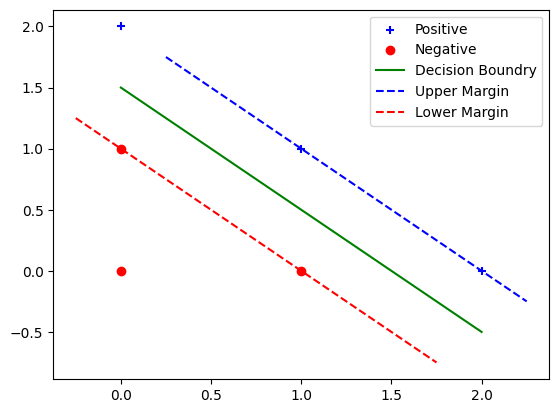

In [14]:
draw_plot(x, y, norm_1_model_glpk)

#### IPOPT

In [15]:
norm_1_model_ipopt = init_svm_model_norm_1(x, y)

solver_name = 'ipopt'     # YOU CAN CHOOSE DESIRED SOLVER

# Non-Linear Programming Solver
opt = pyo.SolverFactory(solver_name, executable='bin/ipopt')

result=opt.solve(norm_1_model_ipopt)
norm_1_model_ipopt.display()

Model unknown

  Variables:
    u : Size=2, Index=feature_index
        Key : Lower : Value              : Upper : Fixed : Stale : Domain
          0 :     0 : 2.0000227547937643 :  None : False : False : NonNegativeReals
          1 :     0 : 2.0000213919526333 :  None : False : False : NonNegativeReals
    w : Size=2, Index=feature_index
        Key : Lower : Value             : Upper : Fixed : Stale : Domain
          0 :  None : 2.000022764793762 :  None : False : False :  Reals
          1 :  None : 2.000021401945126 :  None : False : False :  Reals
    b : Size=1, Index=None
        Key  : Lower : Value              : Upper : Fixed : Stale : Domain
        None :  None : -3.000030530967811 :  None : False : False :  Reals
    relax : Size=6, Index=data_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   0.0 :  None : False : False : NonNegativeReals
          1 :     0 :   0.0 :  None : False : False : NonNegativeReals
          2 :     0 : 

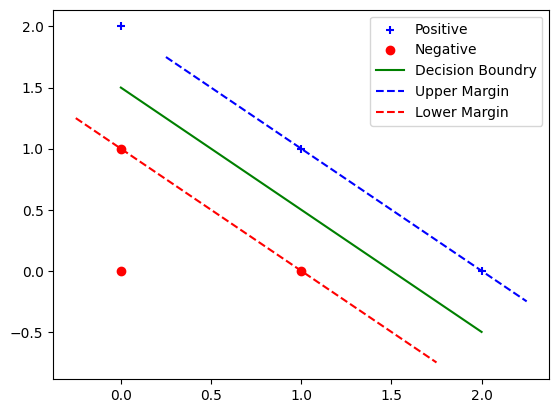

In [16]:
draw_plot(x, y, norm_1_model_ipopt)

### Blobs Dataset

#### GLPK

In [17]:
norm_1_model_blob_glpk = init_svm_model_norm_1(x_blob, y_blob)

solver_name = 'glpk'     # YOU CAN CHOOSE DESIRED SOLVER

# Linear Programming Solver
opt = pyo.SolverFactory(solver_name)

result=opt.solve(norm_1_model_blob_glpk)

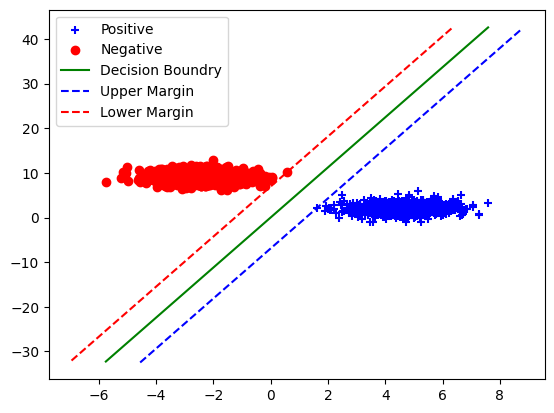

In [18]:
draw_plot(x_blob, y_blob, norm_1_model_blob_glpk)

#### IPOPT

In [19]:
norm_1_model_blob_ipopt = init_svm_model_norm_1(x_blob, y_blob)

solver_name = 'ipopt'     # YOU CAN CHOOSE DESIRED SOLVER

# Non-Linear Programming Solver
opt = pyo.SolverFactory(solver_name, executable='bin/ipopt')

result=opt.solve(norm_1_model_blob_ipopt)

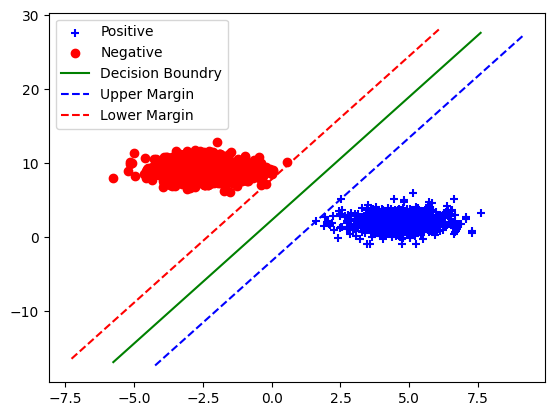

In [20]:
draw_plot(x_blob, y_blob, norm_1_model_blob_ipopt)

### Moons Dataset

#### GLPK

In [21]:
norm_1_model_moon_glpk = init_svm_model_norm_1(x_moon, y_moon)

solver_name = 'glpk'     # YOU CAN CHOOSE DESIRED SOLVER

# Linear Programming Solver
opt = pyo.SolverFactory(solver_name)

result=opt.solve(norm_1_model_moon_glpk)

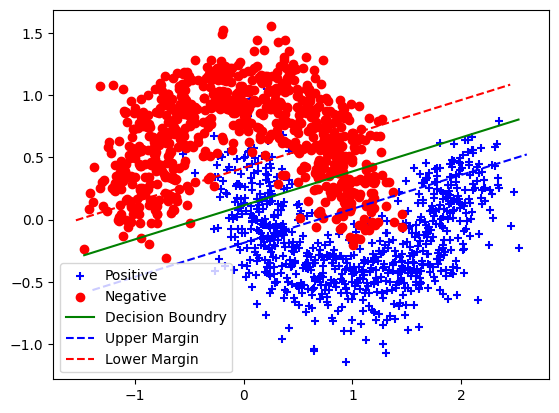

In [22]:
draw_plot(x_moon, y_moon, norm_1_model_moon_glpk)

#### IPOPT

In [23]:
norm_1_model_moon_ipopt = init_svm_model_norm_1(x_moon, y_moon)

solver_name = 'ipopt'     # YOU CAN CHOOSE DESIRED SOLVER

# Non-Linear Programming Solver
opt = pyo.SolverFactory(solver_name, executable='bin/ipopt')

result=opt.solve(norm_1_model_moon_ipopt)

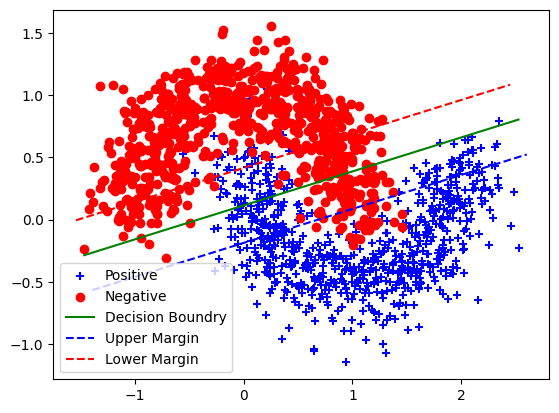

In [24]:
draw_plot(x_moon, y_moon, norm_1_model_moon_ipopt)

### Circles Dataset

#### GLPK

In [25]:
norm_1_model_circle_glpk = init_svm_model_norm_1(x_circle, y_circle)

solver_name = 'glpk'     # YOU CAN CHOOSE DESIRED SOLVER

# Linear Programming Solver
opt = pyo.SolverFactory(solver_name)

result=opt.solve(norm_1_model_circle_glpk)

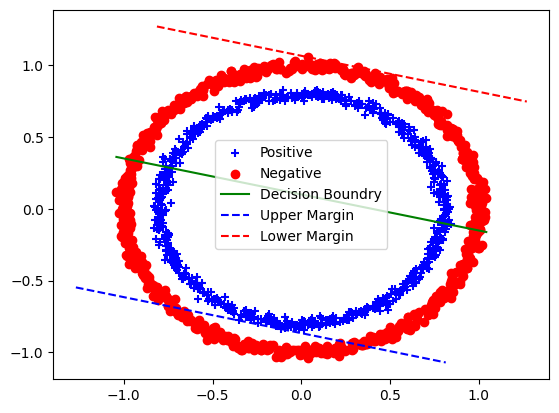

In [26]:
draw_plot(x_circle, y_circle, norm_1_model_circle_glpk)

#### IPOPT

In [27]:
norm_1_model_circle_ipopt = init_svm_model_norm_1(x_circle, y_circle)

solver_name = 'ipopt'     # YOU CAN CHOOSE DESIRED SOLVER

# Non-Linear Programming Solver
opt = pyo.SolverFactory(solver_name, executable='bin/ipopt')

result=opt.solve(norm_1_model_circle_ipopt)

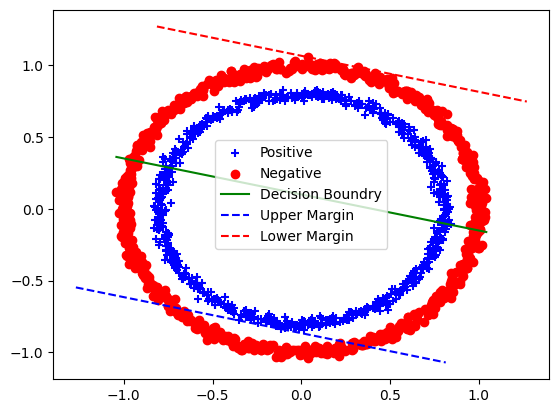

In [28]:
draw_plot(x_circle, y_circle, norm_1_model_circle_ipopt)

## Norm 2 SVM

### Simple Dataset

In [29]:
norm_2_model = init_svm_model_norm_2(x, y)

solver_name = 'ipopt'

# Non-Linear Programming Solver
opt = pyo.SolverFactory(solver_name, executable='bin/ipopt')

result=opt.solve(norm_2_model)
norm_2_model.display()

Model unknown

  Variables:
    w : Size=2, Index=feature_index
        Key : Lower : Value              : Upper : Fixed : Stale : Domain
          0 :  None : 2.0000056794673253 :  None : False : False :  Reals
          1 :  None : 2.0000056794673253 :  None : False : False :  Reals
    b : Size=1, Index=None
        Key  : Lower : Value              : Upper : Fixed : Stale : Domain
        None :  None : -3.000007952467737 :  None : False : False :  Reals
    relax : Size=6, Index=data_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :   0.0 :  None : False : False : NonNegativeReals
          1 :     0 :   0.0 :  None : False : False : NonNegativeReals
          2 :     0 :   0.0 :  None : False : False : NonNegativeReals
          3 :     0 :   0.0 :  None : False : False : NonNegativeReals
          4 :     0 :   0.0 :  None : False : False : NonNegativeReals
          5 :     0 :   0.0 :  None : False : False : NonNegativeReals

  Objectives

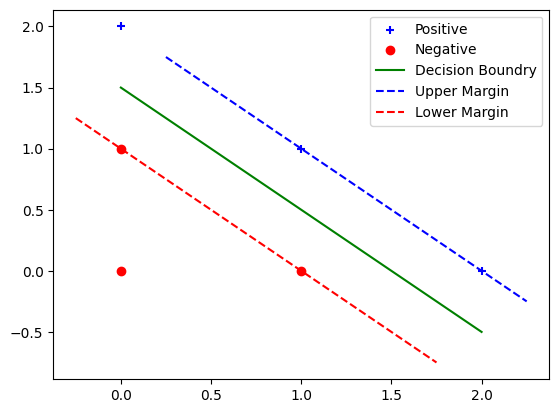

In [30]:
draw_plot(x, y, norm_2_model)

### Blobs Dataset

In [31]:
norm_2_model_blob = init_svm_model_norm_2(x_blob, y_blob)

solver_name = 'ipopt'

# Non-Linear Programming Solver
opt = pyo.SolverFactory(solver_name, executable='bin/ipopt')

result=opt.solve(norm_2_model_blob)

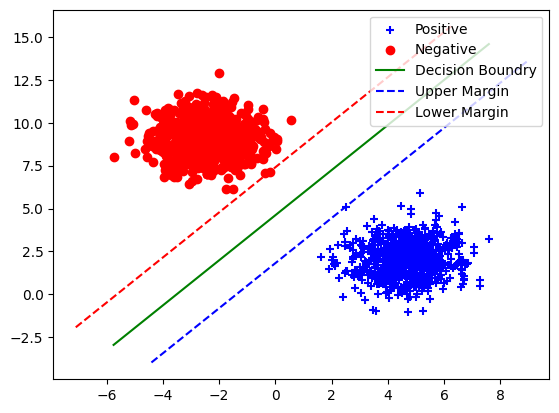

In [32]:
draw_plot(x_blob, y_blob, norm_2_model_blob)

### Moons Dataset

In [33]:
norm_2_model_moon = init_svm_model_norm_2(x_moon, y_moon)

solver_name = 'ipopt'

# Non-Linear Programming Solver
opt = pyo.SolverFactory(solver_name, executable='bin/ipopt')

result=opt.solve(norm_2_model_moon)

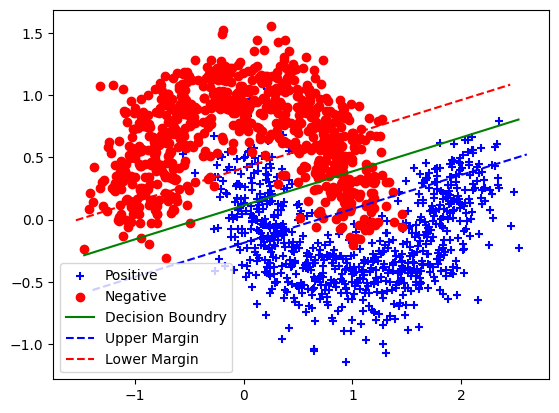

In [34]:
draw_plot(x_moon, y_moon, norm_2_model_moon)

### Circles Dataset

In [35]:
norm_2_model_circle = init_svm_model_norm_2(x_circle, y_circle)

solver_name = 'ipopt'

# Non-Linear Programming Solver
opt = pyo.SolverFactory(solver_name, executable='bin/ipopt')

result=opt.solve(norm_2_model_circle)

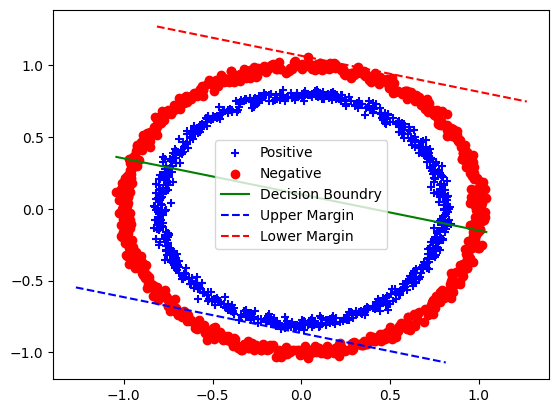

In [36]:
draw_plot(x_circle, y_circle, norm_2_model_circle)

## Effect of Coefficients of Relax Parameter

### C = $1$

In [54]:
norm_2_model_circle_c1 = init_svm_model_norm_2(x_circle, y_circle, C=1)

solver_name = 'ipopt'

# Non-Linear Programming Solver
opt = pyo.SolverFactory(solver_name, executable='bin/ipopt')

result=opt.solve(norm_2_model_circle_c1)

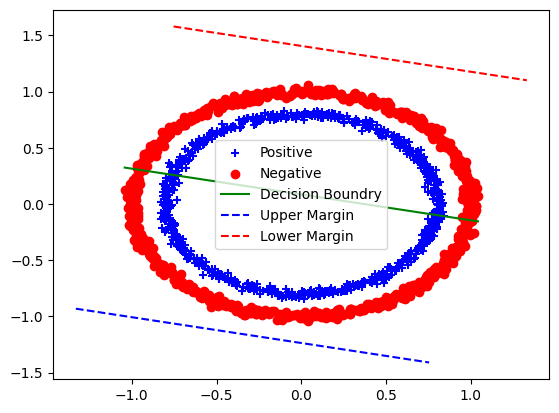

In [55]:
draw_plot(x_circle, y_circle, norm_2_model_circle_c1)

### C = $10$

In [60]:
norm_2_model_circle_c_10 = init_svm_model_norm_2(x_circle, y_circle, C=10)

solver_name = 'ipopt'

# Non-Linear Programming Solver
opt = pyo.SolverFactory(solver_name, executable='bin/ipopt')

result=opt.solve(norm_2_model_circle_c_10)

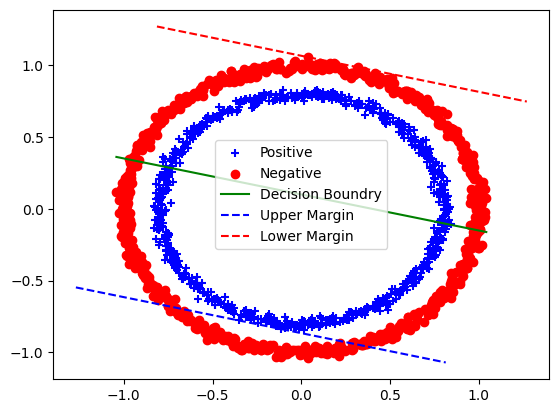

In [61]:
draw_plot(x_circle, y_circle, norm_2_model_circle_c_10)

### C = $10^3$

In [56]:
norm_2_model_circle_c_1e3 = init_svm_model_norm_2(x_circle, y_circle, C=1e3)

solver_name = 'ipopt'

# Non-Linear Programming Solver
opt = pyo.SolverFactory(solver_name, executable='bin/ipopt')

result=opt.solve(norm_2_model_circle_c_1e3)

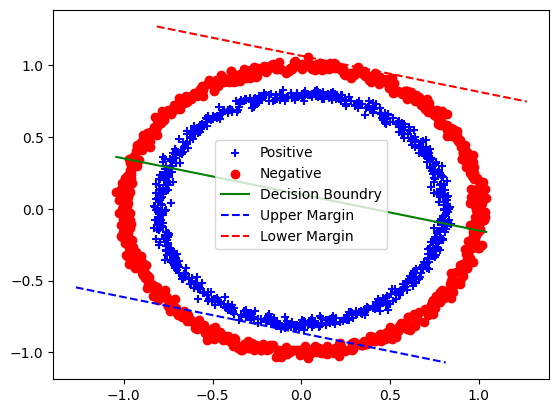

In [57]:
draw_plot(x_circle, y_circle, norm_2_model_circle_c_1e3)

### C = $10^6$

In [58]:
norm_2_model_circle_c_1e6 = init_svm_model_norm_2(x_circle, y_circle, C=1e6)

solver_name = 'ipopt'

# Non-Linear Programming Solver
opt = pyo.SolverFactory(solver_name, executable='bin/ipopt')

result=opt.solve(norm_2_model_circle_c_1e6)

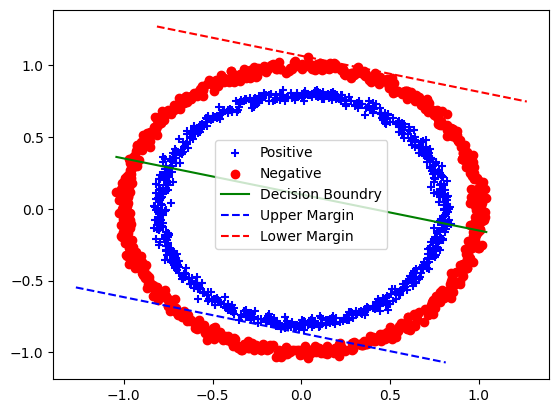

In [59]:
draw_plot(x_circle, y_circle, norm_2_model_circle_c_1e6)

## Plot Output

In [11]:
def draw_plot(x, y, model):
    
    # find range of spread of data
    min_x = x.min(axis=0)[0]
    max_x = x.max(axis=0)[0]
    
    # separate data based on data label
    x_pos = x[y == 1]
    x_neg = x[y == -1]
    
    # plot scatter plot of points
    plt.scatter(x_pos[:, 0], x_pos[:, 1], c='b', marker='+', label='Positive')
    plt.scatter(x_neg[:, 0], x_neg[:, 1], c='r', marker='o', label='Negative')
    
    # Unbox coefficients
    w_0 = pyo.value(model.w[0])
    w_1 = pyo.value(model.w[1])
    b   = pyo.value(model.b)
    W = np.array([w_0, w_1])
    
    # Compute slope and intercept of the decision boundry line
    a_ = -w_0 / w_1
    b_ = -b / w_1
    
    # Compute margin length and unit vector of support vector
    W_norm_2 = np.linalg.norm(W)
    W_hat = W / W_norm_2
    margin = 1/ W_norm_2

    # plot decision boundries and upper and lower margins
    xx = np.linspace(min_x, max_x)
    yy = a_ * xx + b_
    boundry = np.vstack([xx, yy]).T
    margin_up = boundry + W_hat * margin
    margin_down = boundry - W_hat * margin
    plt.plot(boundry[:, 0], boundry[:, 1], 'g', label='Decision Boundry')
    plt.plot(margin_up[:, 0], margin_up[:, 1], 'b--', label='Upper Margin')
    plt.plot(margin_down[:, 0], margin_down[:, 1], 'r--', label='Lower Margin')
    plt.legend()


# References
- [Support Vector Machine — Introduction to Machine Learning Algorithms](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47)
- [How to create a sample dataset using Python Scikit-learn?](https://www.tutorialspoint.com/how-to-create-a-sample-dataset-using-python-scikit-learn)
- [SVM Classification with sklearn.svm.SVC: How To Plot A Decision Boundary With Margins in 2D Space](https://medium.com/geekculture/svm-classification-with-sklearn-svm-svc-how-to-plot-a-decision-boundary-with-margins-in-2d-space-7232cb3962c0)

----